In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs
#
from copy import deepcopy as cp

def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [4]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'

Figures will be saved in: /home/561/erd561/figures/SAMexp/t13_Ekman_transport-old



In [5]:
%%time

from dask.distributed import Client
c = Client()
print(c)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:34026' processes=4 threads=8, memory=33.67 GB>
CPU times: user 650 ms, sys: 148 ms, total: 798 ms
Wall time: 3.09 s


In [6]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

# nyf_years = np.arange(477, 487)
ctrl_years = np.arange(521, 531)
# hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(596, 606)

# nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
# hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

# for y in nyf_years:
#     path1.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
# #     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
20
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/

In [7]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2,y in zip(path1, path2, arange(0,20)):
    if p1 == path1[0]:
        SST = \
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').assign_coords(year=y)
        pme_river = \
                xr.open_dataset(p1, decode_times=False).\
                pme_river.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
        ekman_heat = \
                xr.open_dataset(p2, decode_times=False).\
                ekman_heat.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
        
    else:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').assign_coords(year=y)
            ], 'year'
            )
        pme_river = \
            xr.concat([
                pme_river,
                xr.open_dataset(p1, decode_times=False).\
                pme_river.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
            ], 'year'
            )
        ekman_heat = \
            xr.concat([
                ekman_heat,
                xr.open_dataset(p2, decode_times=False).\
                ekman_heat.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
            ], 'year'
            )
        
    print(str(p1) + ' OK')

xt_ocean = pme_river.xt_ocean
xt_ocean_corrected = xt_ocean + 360
SST = SST.assign_coords(xt_ocean=xt_ocean_corrected)
pme_river = pme_river.assign_coords(xt_ocean=xt_ocean_corrected)
ekman_heat = ekman_heat.assign_coords(xt_ocean=xt_ocean_corrected)

SST = SST.assign_coords(year=years)
pme_river = pme_river.assign_coords(year=years)
ekman_heat = ekman_heat.assign_coords(year=years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output527/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output528/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output529/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output530/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output598/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output599/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output600/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output601/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output602/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output603/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output604/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output605/ocean_month.nc OK
CPU times: user 24.6 s, sys: 4.2 s, total: 28.8 s
Wall time: 52 s


In [8]:
%%time

lon = [100-360, 170-360]
lat = [-60, -10]

for p1,p2,y in zip(path1, path2, arange(0,20)):
    if p1 == path1[0]:
        u = \
            xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').assign_coords(year=y)*100
        
        v = \
            xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').assign_coords(year=y)*100
        
        print(str(p1) + ' OK')
        
    else:
        u = \
            xr.concat([
                u,
                xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').assign_coords(year=y)*100
            ], 'year'
            )
        
        v = \
            xr.concat([
                v,
                xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').assign_coords(year=y)*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
print(u)
print(v)

xu_ocean = v.xu_ocean
xu_ocean_corrected = xu_ocean + 360

u = u.assign_coords(xu_ocean=xu_ocean_corrected)
v = v.assign_coords(xu_ocean=xu_ocean_corrected)

u = u.assign_coords(year=years)
v = v.assign_coords(year=years)

/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output527/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output528/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output529/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output530/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output598/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output599/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output600/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output601/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output602/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output603/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output604/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output605/ocean_month.nc OK
<xarray.DataArray 'u' (year: 20, yu_ocean: 261, xu_ocean: 281)>
array([[[  3.2855506 ,   4.528485  ,   6.2835426 , ...,  10.597758  ,
          11.012561  ,  11.406698  ],
        [  5.5920067 ,   6.4569197 ,   7.3349676 , ...,  13.240661  ,
          13.403713  ,  13.1507845 ],
        [  7.532708  ,   8.177992  ,   8.922196  , ...,  15.91527   ,
          15.466502  ,  14.188112  ],
        ...,
        [-16.090137  , -16.745651  , -17.028225  , ...,  -2.9880366 ,
          -2.7440085 ,  -2.487271  ],
        [-15.820888  , -16.248922  , -16.460497  , ...,  -2.7115405 ,
          -2.4391437 ,  -2.222546  ],
        [-15.3850975 , -15.626385  , -15.716727  , ...,  -1.9782894 ,
          -1.9235945 ,  -1.734204  ]],

       [[  1.794028  ,   2.0332797 ,   3.572821  , ...,  17.847347  ,
          19.381922  ,  20.56075   ],
        [  3.1518393 ,   4.888114  ,   7.128492  , ...,  20.06609   ,
          21.697

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
%%time

lon = [70-360, 220-360]
lat = [-80, 0]

for p1,p2,y in zip(path1, path2, arange(0,20)):
    if p1 == path1[0]:
        tx_trans = \
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
        
    else:
        tx_trans = \
            xr.concat([
                tx_trans,
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').assign_coords(year=y)
            ], 'year'
            )
        
    print(str(p1) + ' OK')

xu_ocean = tx_trans.xu_ocean
xu_ocean_corrected = xu_ocean + 360

tx_trans = tx_trans.assign_coords(xu_ocean=xu_ocean_corrected)

tx_trans = tx_trans.assign_coords(year=years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output527/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output528/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output529/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output530/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc OK
/g/data/e14/

In [10]:
# SST_hist5069 = SST.sel(year=slice(0,9)).mean(dim='year')
# SST_rcp85 = SST.sel(year=slice(10,19)).mean(dim='year')

# pme_river_hist5069 = pme_river.sel(year=slice(0,9)).mean(dim='year')
# pme_river_rcp85 = pme_river.sel(year=slice(10,19)).mean(dim='year')

tx_trans_hist5069 = tx_trans.sel(year=slice(0,9)).mean(dim='year').cumsum('yt_ocean').sum(dim='st_ocean')
tx_trans_rcp85 = tx_trans.sel(year=slice(10,19)).mean(dim='year').cumsum('yt_ocean').sum(dim='st_ocean')

mask = tx_trans.sel(year=0, method='nearest').sel(st_ocean=0, method='nearest')
tx_trans_hist5069 = tx_trans_hist5069.where(np.isfinite(mask), np.nan)
tx_trans_rcp85 = tx_trans_rcp85.where(np.isfinite(mask), np.nan)

# ekman_heat_hist5069 = ekman_heat.sel(year=slice(0,9)).mean(dim='year')/1000
# ekman_heat_rcp85 = ekman_heat.sel(year=slice(10,19)).mean(dim='year')/1000

u_hist5069 = u.sel(year=slice(0,9)).mean(dim='year')
u_rcp85 = u.sel(year=slice(10,19)).mean(dim='year')

v_hist5069 = v.sel(year=slice(0,9)).mean(dim='year')
v_rcp85 = v.sel(year=slice(10,19)).mean(dim='year')

In [14]:
u

<xarray.DataArray 'u' (year: 20, yu_ocean: 261, xu_ocean: 281)>
array([[[  3.2855506 ,   4.528485  ,   6.2835426 , ...,  10.597758  ,
          11.012561  ,  11.406698  ],
        [  5.5920067 ,   6.4569197 ,   7.3349676 , ...,  13.240661  ,
          13.403713  ,  13.1507845 ],
        [  7.532708  ,   8.177992  ,   8.922196  , ...,  15.91527   ,
          15.466502  ,  14.188112  ],
        ...,
        [-16.090137  , -16.745651  , -17.028225  , ...,  -2.9880366 ,
          -2.7440085 ,  -2.487271  ],
        [-15.820888  , -16.248922  , -16.460497  , ...,  -2.7115405 ,
          -2.4391437 ,  -2.222546  ],
        [-15.3850975 , -15.626385  , -15.716727  , ...,  -1.9782894 ,
          -1.9235945 ,  -1.734204  ]],

       [[  1.794028  ,   2.0332797 ,   3.572821  , ...,  17.847347  ,
          19.381922  ,  20.56075   ],
        [  3.1518393 ,   4.888114  ,   7.128492  , ...,  20.06609   ,
          21.697483  ,  22.393345  ],
        [  5.150016  ,   7.864752  ,  10.382423  , ...,  

In [11]:
%%time

lon = [-71, -69]
lat = [-90, -54]

for p1,p2,y in zip(path1, path2, arange(0,20)):
    if p1 == path1[0]:
        tx_trans_DP = \
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sum(dim='st_ocean').\
                cumsum('yt_ocean').\
                mean(dim='time').assign_coords(year=y)
        
    else:
        tx_trans_DP = \
            xr.concat([
                tx_trans_DP,
                xr.open_dataset(p2, decode_times=False).\
                tx_trans.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sum(dim='st_ocean').\
                cumsum('yt_ocean').\
                mean(dim='time').assign_coords(year=y)
            ], 'year'
            )
        
    print(str(p1) + ' OK')
    
tx_trans_DP = tx_trans_DP.assign_coords(year=years)

tx_trans_DP_hist5069 = tx_trans_DP.max(dim='yt_ocean').mean(dim='xu_ocean').sel(year=slice(0,9)).mean(dim='year')
tx_trans_DP_rcp85 = tx_trans_DP.max(dim='yt_ocean').mean(dim='xu_ocean').sel(year=slice(10,19)).mean(dim='year')

/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output521/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output522/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output523/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output524/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output525/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output526/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output527/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output528/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output529/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output530/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output596/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output597/ocean_month.nc OK
/g/data/e14/

Bbox(x0=0.125, y0=0.7498275862068966, x1=0.8999999999999999, y1=0.88)
[0.125, 0.7498275862068966, 0.8999999999999999, 0.88]
Bbox(x0=0.125, y0=0.5936206896551723, x1=0.8999999999999999, y1=0.7237931034482759)
[0.125, 0.5936206896551723, 0.8999999999999999, 0.7237931034482759]
Bbox(x0=0.125, y0=0.43741379310344825, x1=0.8999999999999999, y1=0.5675862068965517)
[0.125, 0.43741379310344825, 0.8999999999999999, 0.5675862068965517]
Bbox(x0=0.125, y0=0.12499999999999989, x1=0.6264705882352941, y1=0.41137931034482755)
[0.125, 0.1349999999999999, 0.6214705882352941, 0.39137931034482754]
Bbox(x0=0.6720588235294118, y0=0.12499999999999989, x1=0.9000000000000001, y1=0.41137931034482755)
[0.6370588235294118, 0.1349999999999999, 0.9000000000000001, 0.39137931034482754]
(92,)
(132,)
(132, 92)
(132, 92)
(132, 92)
(132, 92)
(132, 92)
[[ 3.5577896   3.4333532   3.476357   ...  1.3058062   0.7451334
   1.0027103 ]
 [ 3.8731155   3.745358    3.9411328  ...  1.4006367   1.4608717
   0.89453316]
 [ 4.545656

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  s)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  s)


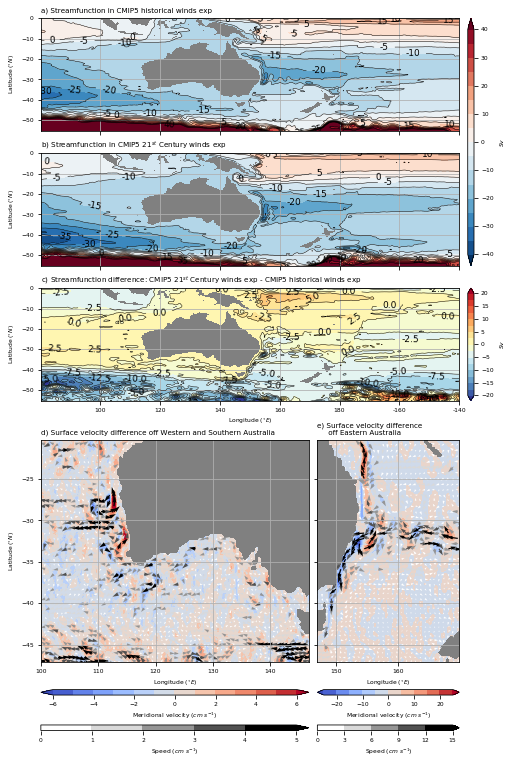

In [13]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
def bbox(pos):
    return matplotlib.transforms.Bbox(np.array([[pos[0],pos[1]],[pos[2],pos[3]]]))

fig = plt.figure() 
fig.set_size_inches(7.5,12)
matplotlib.rcParams.update({'font.size': 6}) 
col = 3
row = 5

ax = plt.subplot2grid((row, 2), (0, 0), rowspan=1, colspan=3)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1, pos.y1]
print(pos_plot)
cont_lev = arange(-40,40,5)
anom = -tx_trans_hist5069 + tx_trans_DP_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdBu_r, extend='both')
cs = anom.plot.contour(levels=cont_lev, linewidths=0.5, colors='k', linestyles='-')
plt.clabel(cs, levels=cs.levels[::2], fmt='%1.0f', fontsize=9)

ax.set_position(bbox(pos_plot))
plt.grid()
plt.title('')
plt.title(r'a) Streamfunction in CMIP5 historical winds exp', loc='left')
plt.xlabel('')
plt.ylabel('')
# plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
plt.gca().set_ylim(-55,0)
ax.set_facecolor('gray')
plt.ylabel('Latitude ($^{\circ}N$)')




ax = plt.subplot2grid((row, 2), (1, 0), rowspan=1, colspan=3)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1, pos.y1]
print(pos_plot)
# cont_lev = arange(-40,40,5)
anom = -tx_trans_rcp85 + tx_trans_DP_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdBu_r, extend='both')
cs = anom.plot.contour(levels=cont_lev, linewidths=0.5, colors='k', linestyles='-')
plt.clabel(cs, levels=cs.levels[::2], fmt='%1.0f', fontsize=9)
ax.set_position(bbox(pos_plot))
plt.grid()
plt.title('')
plt.title(r'b) Streamfunction in CMIP5 $21^{st}$ Century winds exp', loc='left')
plt.xlabel('')
plt.ylabel('')
# plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
plt.gca().set_ylim(-55,0)
ax.set_facecolor('gray')
plt.ylabel('Latitude ($^{\circ}N$)')
axins = inset_axes(ax,
                   width="1.5%",  # width = 5% of parent_bbox width
                   height="220%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$Sv$', cax=axins)



ax = plt.subplot2grid((row, 2), (2, 0), rowspan=1, colspan=3)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1, pos.y1]
print(pos_plot)
cont_lev = arange(-20,20,2.5)
anom = -tx_trans_rcp85 + tx_trans_hist5069
# dummy = tx_trans_hist5069*0
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdYlBu_r, extend='both')
cs = anom.plot.contour(levels=cont_lev, linewidths=0.5, colors='k', linestyles='-')
plt.clabel(cs, levels=cont_lev, fmt='%1.1f', fontsize=9)
ax.set_position(bbox(pos_plot))
plt.grid()
plt.title('')
plt.title(r'c) Streamfunction difference: CMIP5 $21^{st}$ Century winds exp - CMIP5 historical winds exp', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.ylabel('Latitude ($^{\circ}N$)')
plt.gca().set_ylim(-55,0)
# plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels([80, 100, 120, 140, 160, 180, -160, -140])
ax.set_facecolor('gray')
axins = inset_axes(ax,
                   width="1.5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$Sv$', cax=axins)


ax = plt.subplot2grid((row, col), (3, 0), rowspan=2, colspan=2)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.01, pos.x1-0.005, pos.y1-0.02] 
print(pos_plot)
cont_lev = arange(-6, 6, 1)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [100, 147]
Y_LIM = [-47, -20]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')
ax.set_position(bbox(pos_plot))
plt.title('')
n = 3

speed = np.sqrt(U**2 + V**2)
U1 = cp(U)
V1 = cp(V)
U2 = U / speed
V2 = V / speed
tol = 0
U2 = U1 / (U1**2 + V1**2)**(1/4)
V2 = V1 / (U1**2 + V1**2)**(1/4)
speed2 = cp(speed)
# speed2[speed < tol] = np.NaN

vmin=tol
vmax=5
step=5
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# print(X.shape)
# print(Y.shape)
# print(U1.shape)
# print(V1.shape)
# print(U2.shape)
# print(V2.shape)
# print(speed.shape)

# Q1 = plt.quiver(X[0:188:n], 
#                 Y[0:132:n], 
#                 U1[0:132:n, 0:188:n], 
#                 V1[0:132:n, 0:188:n],
#                 width=0.0015, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 facecolor='w', edgecolor='k', linewidth=0.2)

Q2 = plt.quiver(X[0:188:n], 
                Y[0:132:n], 
                U2[0:132:n, 0:188:n], 
                V2[0:132:n, 0:188:n],
                speed2[0:132:n, 0:188:n],
                cmap=cmap, norm=norm,
                width=0.005, scale=80,
                edgecolor='k', linewidth=0)

plt.grid()
plt.title('d) Surface velocity difference off Western and Southern Australia', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.ylabel('Latitude ($^{\circ}N$)')
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="2.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.15, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='horizontal',
                    label=r'Meridional velocity ($cm\ s^{-1}$)', cax=axins)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="2.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.31, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(Q2, orientation='horizontal',
                    label=r'Speed ($cm\ s^{-1}$)', cax=axins, extend='max')
cbar.set_ticks(Q_lev)


ax = plt.subplot2grid((row, col), (3, 2), rowspan=2, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0-0.035, pos.y0+0.01, pos.x1, pos.y1-0.02] 
print(pos_plot)
cont_lev = arange(-25, 25, 5)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [147, 170]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')
ax.set_position(bbox(pos_plot))
plt.title('')
n = 3

speed = np.sqrt(U**2 + V**2)
U1 = cp(U)
V1 = cp(V)
U2 = U / speed
V2 = V / speed
tol = 0
U2 = U1 / (U1**2 + V1**2)**(1/4)
V2 = V1 / (U1**2 + V1**2)**(1/4)
speed2 = cp(speed)
# speed2[speed < tol] = np.NaN

print(X.shape)
print(Y.shape)
print(U1.shape)
print(V1.shape)
print(U2.shape)
print(V2.shape)
print(speed.shape)

print(U1)

vmin=tol
vmax=15
step=5
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# Q1 = plt.quiver(X[0:72:n], 
#                 Y[0:132:n], 
#                 U1[0:132:n, 0:72:n], 
#                 V1[0:132:n, 0:72:n],
#                 norm=norm,
#                 width=0.0015, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 facecolor='w', edgecolor='k', linewidth=0.2)

# Q2 = plt.quiver(X[0:92:n], 
#                 Y[0:132:n], 
#                 U2[0:132:n, 0:92:n], 
#                 V2[0:132:n, 0:92:n],
#                 speed2[0:132:n, 0:92:n],
#                 cmap=cmap, norm=norm,
#                 width=0.0035, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 edgecolor='k', linewidth=0.2)

Q2 = plt.quiver(X[0:92:n], 
                Y[0:132:n], 
                U2[0:132:n, 0:92:n], 
                V2[0:132:n, 0:92:n],
                speed2[0:132:n, 0:92:n],
                cmap=cmap, norm=norm,
                width=0.0085, scale=60,
                edgecolor='k', linewidth=0)

plt.grid()
plt.title('e) Surface velocity difference\n     off Eastern Australia', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.xticks(arange(150,165,10))
plt.gca().set_yticklabels('')
plt.xlabel('Longitude ($^{\circ}E$)')
ax.set_facecolor('gray')
# ax = plt.subplot2grid((row, col), (4, 2), rowspan=1, colspan=1)
# ax_divider = make_axes_locatable(ax)
# cax1 = ax_divider.append_axes("top", size=0.1, pad="2%")
# cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
# cbar.set_label(r'$v$ ($cm\ s^{-1}$)') 
# cax2 = ax_divider.append_axes("top", size=0.1, pad="40%")
# cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
# cbar.set_ticks(Q_lev)
# cbar.set_label(r'$Speed$ ($cm\ s^{-1}$)')
# ax.axis('off')
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="2.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.15, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='horizontal',
                    label=r'Meridional velocity ($cm\ s^{-1}$)', cax=axins)
axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="2.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.31, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(Q2, orientation='horizontal',
                    label=r'Speed ($cm\ s^{-1}$)', cax=axins, extend='max')
cbar.set_ticks(Q_lev)



# fig.tight_layout(pad=0, w_pad=-2, h_pad=-0.5)

output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_3.png', bbox_inches='tight', dpi=300)

In [ ]:
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# def arange(start,end,stride=1):
#     return np.arange(start,end+0.00000001,stride)
# def bbox(pos):
#     return matplotlib.transforms.Bbox(np.array([[pos[0],pos[1]],[pos[2],pos[3]]]))

# fig = plt.figure() 
# fig.set_size_inches(7.5,12)
# matplotlib.rcParams.update({'font.size': 6}) 
# col = 3
# row = 4

# ax = plt.subplot2grid((row, 2), (0, 0), rowspan=1, colspan=1)
# pos = ax.get_position()
# print(pos)
# pos_plot = [pos.x0, pos.y0+0.02, pos.x1+0.025, pos.y1]
# print(pos_plot)
# cont_lev = arange(-40,40,5)
# anom = -tx_trans_hist5069 + tx_trans_DP_hist5069
# contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdBu_r, extend='both')
# cs = anom.plot.contour(levels=cont_lev, linewidths=0.5, colors='k', linestyles='-')
# plt.clabel(cs, levels=cs.levels[::2], fmt='%1.0f')

# ax.set_position(bbox(pos_plot))
# plt.grid()
# plt.title('')
# plt.title(r'a) Streamfunction in CMIP5 historical winds exp', loc='left')
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# # plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels([140, 160, 180, -160, -140, -120, -100, -80])
# plt.gca().set_ylim(-55,0)
# ax.set_facecolor('gray')
# plt.ylabel('Latitude ($^{\circ}N$)')




# ax = plt.subplot2grid((row, 2), (0, 1), rowspan=1, colspan=1)
# pos = ax.get_position()
# print(pos)
# pos_plot = [pos.x0-0.025, pos.y0+0.02, pos.x1, pos.y1]
# print(pos_plot)
# # cont_lev = arange(-40,40,5)
# anom = -tx_trans_rcp85 + tx_trans_DP_hist5069
# contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdBu_r, extend='both')
# cs = anom.plot.contour(levels=cont_lev, linewidths=0.5, colors='k', linestyles='-')
# plt.clabel(cs, levels=cs.levels[::2], fmt='%1.0f')
# ax.set_position(bbox(pos_plot))
# plt.grid()
# plt.title('')
# plt.title(r'b) Streamfunction in CMIP5 $21^{st}$ Century winds exp', loc='left')
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# # plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels([140, 160, 180, -160, -140, -120, -100, -80])
# plt.gca().set_yticklabels('')
# plt.gca().set_ylim(-55,0)
# ax.set_facecolor('gray')
# # plt.ylabel('Latitude ($^{\circ}N$)')
# # axins = inset_axes(ax,
# #                    width="100%",  # width = 5% of parent_bbox width
# #                    height="4%",  # height : 50%
# #                    loc='lower left',
# #                    bbox_to_anchor=(0, -0.12, 1, 1),
# #                    bbox_transform=ax.transAxes,
# #                    borderpad=0)
# # cbar = plt.colorbar(contf, orientation='horizontal',
# #                     label=r'$Sv$', cax=axins)



# ax = plt.subplot2grid((row, 2), (1, 0), rowspan=1, colspan=2)
# pos = ax.get_position()
# print(pos)
# pos_plot = [pos.x0, pos.y0+0.01, pos.x1, pos.y1]
# print(pos_plot)
# # cont_lev = arange(-40,40,5)
# anom = -tx_trans_rcp85 + tx_trans_hist5069
# # dummy = tx_trans_hist5069*0
# contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdBu_r, extend='both')
# cs = anom.plot.contour(levels=cont_lev, linewidths=0.5, colors='k', linestyles='-')
# plt.clabel(cs, levels=arange(-40,40,2.5), fmt='%1.1f', fontsize=7)
# ax.set_position(bbox(pos_plot))
# plt.grid()
# plt.title('')
# plt.title(r'c) Streamfunction: CMIP5 $21^{st}$ Century winds exp - CMIP5 historical winds exp', loc='left')
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('')
# plt.gca().set_ylim(-55,0)
# # plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels([140, 160, 180, -160, -140, -120, -100, -80])
# ax.set_facecolor('gray')
# plt.ylabel('Latitude ($^{\circ}N$)')

# axins = inset_axes(ax,
#                    width="100%",  # width = 5% of parent_bbox width
#                    height="4%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(0, -0.25, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0)
# cbar = plt.colorbar(contf, orientation='horizontal',
#                     label=r'$Sv$', cax=axins)



# # ax = plt.subplot2grid((row, 2), (1, 1), rowspan=1, colspan=1)
# # pos = ax.get_position()
# # print(pos)
# # pos_plot = [pos.x0+0.015, pos.y0, pos.x1, pos.y1-0.02] 
# # print(pos_plot)
# # cont_lev = arange(-1,1,0.2)
# # anom = (pme_river_rcp85 - pme_river_hist5069)*10**5
# # contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.RdBu_r, extend='both')
# # plt.contour(SST_rcp85.xt_ocean, SST_rcp85.yt_ocean, SST_rcp85 - SST_hist5069, 
# #             levels=[0.25], linewidth=1, color='k')
# # ax.set_position(bbox(pos_plot))
# # plt.grid()
# # plt.title('')
# # plt.title(r'd) Mass flux of precipitation - evaporation + river', loc='left')
# # plt.xlabel('Longitude ($^{\circ}E$)')
# # plt.ylabel('')
# # # plt.gca().set_xticks(arange(100,160,10))
# # # plt.gca().set_xticklabels('')
# # # plt.gca().set_yticklabels('')
# # ax.set_facecolor('gray')
# # # plt.ylabel('Latitude ($^{\circ}N$)')
# # axins = inset_axes(ax,
# #                    width="100%",  # width = 5% of parent_bbox width
# #                    height="4%",  # height : 50%
# #                    loc='lower left',
# #                    bbox_to_anchor=(0, -0.25, 1, 1),
# #                    bbox_transform=ax.transAxes,
# #                    borderpad=0)
# # cbar = plt.colorbar(contf, orientation='horizontal',
# #                     label=r'$10^{-5}\ \times\ (kg\ m^{-3})\cdot(m\ s^{-1})$', cax=axins)



# ax = plt.subplot2grid((row, col), (2, 0), rowspan=2, colspan=2)
# pos = ax.get_position()
# print(pos)
# pos_plot = [pos.x0, pos.y0+0.01, pos.x1-0.01, pos.y1-0.05] 
# print(pos_plot)
# cont_lev = arange(-6, 6, 1)
# u_anom = u_rcp85 - u_hist5069
# v_anom = v_rcp85 - v_hist5069
# X_LIM = [100, 147]
# Y_LIM = [-47, -20]
# X = v_anom.xu_ocean[
#     find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
# Y = v_anom.yu_ocean[
#     find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
# Xm, Ym = np.meshgrid(X,Y)
# U = np.array(u_anom[
#     find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
#     find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
# ])
# V = np.array(v_anom[
#     find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
#     find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
# ])
# contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')
# ax.set_position(bbox(pos_plot))
# plt.title('')
# n = 3

# speed = np.sqrt(U**2 + V**2)
# U1 = cp(U)
# V1 = cp(V)
# U2 = U / speed
# V2 = V / speed
# tol = 0
# U2 = U1 / (U1**2 + V1**2)**(1/4)
# V2 = V1 / (U1**2 + V1**2)**(1/4)
# speed2 = cp(speed)
# # speed2[speed < tol] = np.NaN

# vmin=tol
# vmax=5
# step=5
# Q_lev = np.linspace(vmin, vmax, step+1)
# norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
# cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# # print(X.shape)
# # print(Y.shape)
# # print(U1.shape)
# # print(V1.shape)
# # print(U2.shape)
# # print(V2.shape)
# # print(speed.shape)

# # Q1 = plt.quiver(X[0:188:n], 
# #                 Y[0:132:n], 
# #                 U1[0:132:n, 0:188:n], 
# #                 V1[0:132:n, 0:188:n],
# #                 width=0.0015, scale=100,
# #                 headwidth=4.5, headaxislength=3.75, 
# #                 facecolor='w', edgecolor='k', linewidth=0.2)

# Q2 = plt.quiver(X[0:188:n], 
#                 Y[0:132:n], 
#                 U2[0:132:n, 0:188:n], 
#                 V2[0:132:n, 0:188:n],
#                 speed2[0:132:n, 0:188:n],
#                 cmap=cmap, norm=norm,
#                 width=0.005, scale=80,
#                 edgecolor='k', linewidth=0)

# plt.grid()
# plt.title('d) Surface velocity off Western and Southern Australia', loc='left')
# plt.xlabel('')
# plt.ylabel('')
# ax.set_facecolor('gray')
# plt.xlabel('Longitude ($^{\circ}E$)')
# plt.ylabel('Latitude ($^{\circ}N$)')
# axins = inset_axes(ax,
#                    width="100%",  # width = 5% of parent_bbox width
#                    height="1.75%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(0, -0.125, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0)
# cbar = plt.colorbar(contf, orientation='horizontal',
#                     label=r'Meridional velocity ($cm\ s^{-1}$)', cax=axins)
# axins = inset_axes(ax,
#                    width="100%",  # width = 5% of parent_bbox width
#                    height="1.75%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(0, -0.275, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0)
# cbar = plt.colorbar(Q2, orientation='horizontal',
#                     label=r'Speed ($cm\ s^{-1}$)', cax=axins, extend='max')
# cbar.set_ticks(Q_lev)


# ax = plt.subplot2grid((row, col), (2, 2), rowspan=2, colspan=1)
# pos = ax.get_position()
# print(pos)
# pos_plot = [pos.x0-0.04, pos.y0+0.01, pos.x1, pos.y1-0.05] 
# print(pos_plot)
# cont_lev = arange(-25, 25, 5)
# u_anom = u_rcp85 - u_hist5069
# v_anom = v_rcp85 - v_hist5069
# X_LIM = [147, 170]
# X = v_anom.xu_ocean[
#     find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
# Xm, Ym = np.meshgrid(X,Y)
# U = np.array(u_anom[
#     find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
#     find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
# ])
# V = np.array(v_anom[
#     find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
#     find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
# ])
# contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')
# ax.set_position(bbox(pos_plot))
# plt.title('')
# n = 3

# speed = np.sqrt(U**2 + V**2)
# U1 = cp(U)
# V1 = cp(V)
# U2 = U / speed
# V2 = V / speed
# tol = 0
# U2 = U1 / (U1**2 + V1**2)**(1/4)
# V2 = V1 / (U1**2 + V1**2)**(1/4)
# speed2 = cp(speed)
# # speed2[speed < tol] = np.NaN

# print(X.shape)
# print(Y.shape)
# print(U1.shape)
# print(V1.shape)
# print(U2.shape)
# print(V2.shape)
# print(speed.shape)

# print(U1)

# vmin=tol
# vmax=15
# step=5
# Q_lev = np.linspace(vmin, vmax, step+1)
# norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
# cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# # Q1 = plt.quiver(X[0:72:n], 
# #                 Y[0:132:n], 
# #                 U1[0:132:n, 0:72:n], 
# #                 V1[0:132:n, 0:72:n],
# #                 norm=norm,
# #                 width=0.0015, scale=100,
# #                 headwidth=4.5, headaxislength=3.75, 
# #                 facecolor='w', edgecolor='k', linewidth=0.2)

# # Q2 = plt.quiver(X[0:92:n], 
# #                 Y[0:132:n], 
# #                 U2[0:132:n, 0:92:n], 
# #                 V2[0:132:n, 0:92:n],
# #                 speed2[0:132:n, 0:92:n],
# #                 cmap=cmap, norm=norm,
# #                 width=0.0035, scale=100,
# #                 headwidth=4.5, headaxislength=3.75, 
# #                 edgecolor='k', linewidth=0.2)

# Q2 = plt.quiver(X[0:92:n], 
#                 Y[0:132:n], 
#                 U2[0:132:n, 0:92:n], 
#                 V2[0:132:n, 0:92:n],
#                 speed2[0:132:n, 0:92:n],
#                 cmap=cmap, norm=norm,
#                 width=0.0085, scale=60,
#                 edgecolor='k', linewidth=0)

# plt.grid()
# plt.title('e) Surface velocity off Eastern Australia', loc='left')
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks(arange(150,165,10))
# plt.gca().set_yticklabels('')
# plt.xlabel('Longitude ($^{\circ}E$)')
# ax.set_facecolor('gray')
# # ax = plt.subplot2grid((row, col), (4, 2), rowspan=1, colspan=1)
# # ax_divider = make_axes_locatable(ax)
# # cax1 = ax_divider.append_axes("top", size=0.1, pad="2%")
# # cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
# # cbar.set_label(r'$v$ ($cm\ s^{-1}$)') 
# # cax2 = ax_divider.append_axes("top", size=0.1, pad="40%")
# # cbar = plt.colorbar(Q2, cax=cax2, orientation='horizontal', drawedges=True, extend='max')
# # cbar.set_ticks(Q_lev)
# # cbar.set_label(r'$Speed$ ($cm\ s^{-1}$)')
# # ax.axis('off')
# axins = inset_axes(ax,
#                    width="100%",  # width = 5% of parent_bbox width
#                    height="1.75%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(0, -0.125, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0)
# cbar = plt.colorbar(contf, orientation='horizontal',
#                     label=r'Meridional velocity ($cm\ s^{-1}$)', cax=axins)
# axins = inset_axes(ax,
#                    width="100%",  # width = 5% of parent_bbox width
#                    height="1.75%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(0, -0.275, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0)
# cbar = plt.colorbar(Q2, orientation='horizontal',
#                     label=r'Speed ($cm\ s^{-1}$)', cax=axins, extend='max')
# cbar.set_ticks(Q_lev)



# # fig.tight_layout(pad=0, w_pad=-2, h_pad=-0.5)

# output_ls = os.listdir(figures_path)
# if not script_name:
#     script_name = 'test'
# elif script_name not in output_ls:
#     os.mkdir(figures_path + '/' + script_name)
# plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
#             + '_fig1_2.png', bbox_inches='tight', dpi=300)